In [3]:
!pip install torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### What is a Graph Autoencoder?

A Graph Autoencoder (GAE) is a type of neural network designed to learn node embeddings in an unsupervised way by reconstructing a graph from its compressed latent representation.

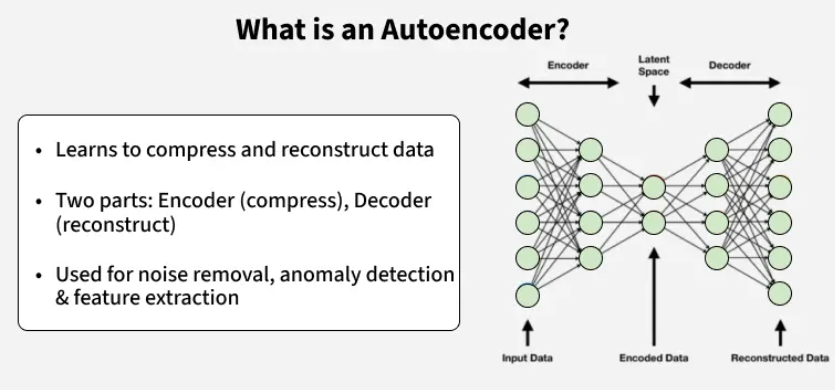

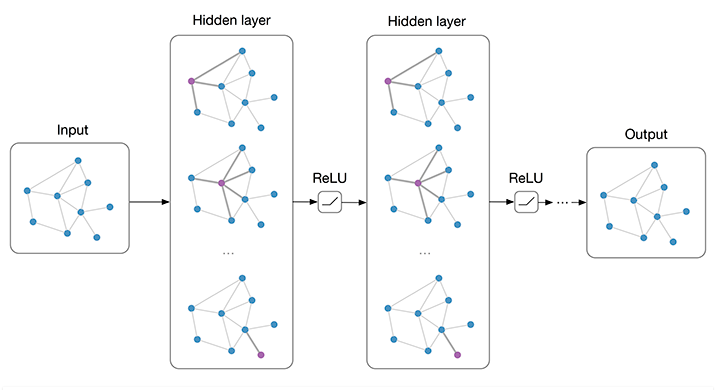

**Encoder:** Learns to compress the graph (usually using a Graph Neural Network like GCN).

**Decoder:** Tries to reconstruct the adjacency matrix (or edge list) from the node embeddings.

## Components of a Graph Autoencoder

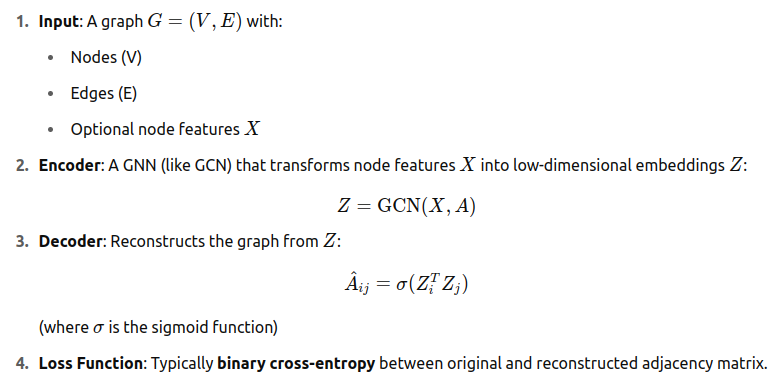

In [12]:
# ✅ Check version of PyTorch Geometric
import torch_geometric
print(torch_geometric.__version__)

# ✅ Import necessary libraries
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid          # Prebuilt citation graph datasets (e.g., Cora, CiteSeer)
from torch_geometric.nn import GCNConv                  # Graph Convolutional Network layer
from torch_geometric.transforms import RandomLinkSplit  # For splitting the graph edges into train/val/test

#  Load the Cora citation graph dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')  # Downloads and processes the dataset
data = dataset[0]                                   # Get the graph data object (features, edge_index, labels, etc.)

#  Split the edges of the graph for unsupervised link prediction
transform = RandomLinkSplit(
    is_undirected=True,               # Assume graph is undirected
    split_labels=True,                # Add labels to pos/neg edge splits
    add_negative_train_samples=True   # Add negative edges (non-existent edges) for training
)
train_data, val_data, test_data = transform(data)  # Split graph into train/validation/test sets

#  Define the Encoder: a simple 2-layer GCN
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)  # First GCN layer (input → hidden)
        self.conv2 = GCNConv(2 * out_channels, out_channels) # Second GCN layer (hidden → latent)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))  # Apply first GCN + ReLU
        return self.conv2(x, edge_index)       # Apply second GCN (no activation here)

#  Define the Graph Autoencoder (GAE) using encoder + inner-product decoder
class GAE(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder  # Plug-in GCNEncoder

    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)  # Generate node embeddings

    def decode(self, z, edge_index):
        # Decoder: inner product between embeddings of connected nodes
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

#  Initialize model, encoder, and optimizer
out_channels = 32                                 # Dimensionality of embedding
encoder = GCNEncoder(dataset.num_node_features, out_channels)  # input: num_node_features
model = GAE(encoder)                              # Autoencoder with GCN encoder
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Optimizer

#  Define training function
def train():
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear previous gradients
    z = model.encode(train_data.x, train_data.edge_index)  # Get latent embeddings from encoder

    # Get positive edge predictions (existing edges)
    pos_edge_index = train_data.pos_edge_label_index
    pos_score = model.decode(z, pos_edge_index)   # Predict scores for positive edges
    pos_label = torch.ones(pos_score.size(0))     # True label is 1 for existing edges

    # Get negative edge predictions (non-existent edges)
    neg_edge_index = train_data.neg_edge_label_index
    neg_score = model.decode(z, neg_edge_index)   # Predict scores for negative edges
    neg_label = torch.zeros(neg_score.size(0))    # True label is 0 for non-existent edges

    # Combine scores and labels
    scores = torch.cat([pos_score, neg_score], dim=0)   # All predicted scores
    labels = torch.cat([pos_label, neg_label], dim=0)   # Corresponding ground-truth labels

    # Compute binary cross-entropy loss
    loss = F.binary_cross_entropy_with_logits(scores, labels)
    loss.backward()    # Backpropagate the loss
    optimizer.step()   # Update model parameters
    return loss.item() # Return the scalar loss value

#  Define test function (evaluates on test edges)
@torch.no_grad()  # Disable gradient tracking for faster inference
def test():
    model.eval()  # Set model to evaluation mode
    z = model.encode(train_data.x, train_data.edge_index)  # Use train edges to get embeddings

    # Predict scores for test positive and negative edges
    pos_edge_index = test_data.pos_edge_label_index
    neg_edge_index = test_data.neg_edge_label_index
    pos_score = torch.sigmoid(model.decode(z, pos_edge_index))
    neg_score = torch.sigmoid(model.decode(z, neg_edge_index))

    # Calculate AUC (Area Under Curve) for link prediction
    from sklearn.metrics import roc_auc_score
    y_true = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))])
    y_pred = torch.cat([pos_score, neg_score])
    return roc_auc_score(y_true.cpu(), y_pred.cpu())  # Return AUC score

#  Training loop
for epoch in range(1, 201):
    loss = train()      # Train model for one epoch
    auc = test()        # Evaluate model on test data
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, AUC: {auc:.4f}')  # Print progress every 20 epochs


2.6.1
Epoch 20, Loss: 0.5055, AUC: 0.8405
Epoch 40, Loss: 0.3114, AUC: 0.8351
Epoch 60, Loss: 0.1774, AUC: 0.7877
Epoch 80, Loss: 0.0726, AUC: 0.7571
Epoch 100, Loss: 0.0178, AUC: 0.7408
Epoch 120, Loss: 0.0038, AUC: 0.7363
Epoch 140, Loss: 0.0013, AUC: 0.7349
Epoch 160, Loss: 0.0007, AUC: 0.7346
Epoch 180, Loss: 0.0005, AUC: 0.7343
Epoch 200, Loss: 0.0004, AUC: 0.7327
